# **Предсказывание количества суицидов**
Суть проекта заключается в построении регрессионой модели предсказывания количества суицидов при определенных показателях. \
Проект является учебным и ставит перед собой цель опробробывать основной процесс получения, анализа и обработки данных для построения регрессионной модели. \

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Получим данные из Kaggle. Лицензирование позволяет использовать данные в учебных некомерческих целях.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("russellyates88/suicide-rates-overview-1985-to-2016")

print("Path to dataset files:", path)

100%|██████████| 397k/397k [00:00<00:00, 33.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/russellyates88/suicide-rates-overview-1985-to-2016/versions/1


In [ ]:
import os

df = pd.read_csv(os.path.join(path, "master.csv"))
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


Пока наблюдаем в данных категориальные переменные, такие как: страна, диапазон возрастов, пол и т.д. Поскольку модели лучше работают с числовыми значениями, то стоит придумать, как их преобразовать.

Колонка где объединили **название страны и год стоит также убрать**. \
Дальнейший анализ необходимости определенных атрибутов будет основываться на значении корреляции

На мое субъективное мнение, эффективным решением данной задачи будет являться создание множества маленьких моделей и объединение их воедино. Т.е. для определенной страны будет создана модель, предсказывающая кол-во суицидов на какой-то год.


1.   Добавление новых данных для обучения модели будет облегчено



In [ ]:
# Выберем для начала USA
usa_df = df[df.country == 'United States'].reset_index(drop=True)
usa_df

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,United States,1985,male,75+ years,2177,4064000,53.57,United States1985,0.841,"4,346,734,000,000",19693,G.I. Generation
1,United States,1985,male,55-74 years,5302,17971000,29.50,United States1985,0.841,"4,346,734,000,000",19693,G.I. Generation
2,United States,1985,male,25-34 years,5134,20986000,24.46,United States1985,0.841,"4,346,734,000,000",19693,Boomers
3,United States,1985,male,35-54 years,6053,26589000,22.77,United States1985,0.841,"4,346,734,000,000",19693,Silent
4,United States,1985,male,15-24 years,4267,19962000,21.38,United States1985,0.841,"4,346,734,000,000",19693,Generation X
...,...,...,...,...,...,...,...,...,...,...,...,...
367,United States,2015,female,25-34 years,1444,21555712,6.70,United States2015,NaN,"18,120,714,000,000",60387,Millenials
368,United States,2015,female,15-24 years,1132,21633813,5.23,United States2015,NaN,"18,120,714,000,000",60387,Millenials
369,United States,2015,female,75+ years,540,11778666,4.58,United States2015,NaN,"18,120,714,000,000",60387,Silent
370,United States,2015,male,5-14 years,255,21273987,1.20,United States2015,NaN,"18,120,714,000,000",60387,Generation Z


In [ ]:
usa_df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,372.000000,372.000000,3.720000e+02,372.000000,120.000000,372.000000
mean,2000.000000,2779.604839,2.165061e+07,13.819812,0.891600,39269.612903
std,8.956318,2752.716420,9.448630e+06,13.229875,0.024741,12334.117581
min,1985.000000,50.000000,4.064000e+06,0.260000,0.841000,19693.000000
25%,1992.000000,558.750000,1.818545e+07,3.972500,0.876000,27760.000000
50%,2000.000000,2193.000000,2.037547e+07,6.890000,0.903000,39218.000000
75%,2008.000000,4145.500000,2.261694e+07,23.305000,0.912000,51585.000000
max,2015.000000,11767.000000,4.380521e+07,58.950000,0.915000,60387.000000


Как мы можем заметить значение HDI for year является почти наполовину пустым. У нас есть множество методов для заполнения такого столбца, например, найти новые данные, однако, я считаю что стоит просто убрать данную колонку, ведь наврядли предсказание поможет восстановить данные значения.

In [ ]:
usa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             372 non-null    object 
 1   year                372 non-null    int64  
 2   sex                 372 non-null    object 
 3   age                 372 non-null    object 
 4   suicides_no         372 non-null    int64  
 5   population          372 non-null    int64  
 6   suicides/100k pop   372 non-null    float64
 7   country-year        372 non-null    object 
 8   HDI for year        120 non-null    float64
 9    gdp_for_year ($)   372 non-null    object 
 10  gdp_per_capita ($)  372 non-null    int64  
 11  generation          372 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 35.0+ KB


## Создаем test-set

In [ ]:
np.random.seed(42)
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = shuffle_and_split_data(usa_df, 0.2)

In [ ]:
train_set.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,298.000000,298.000000,2.980000e+02,298.000000,99.000000,298.000000
mean,2000.385906,2800.510067,2.181673e+07,13.732215,0.892000,39834.355705
std,8.890016,2815.183879,9.602879e+06,13.122433,0.023963,12278.209793
min,1985.000000,50.000000,4.178000e+06,0.260000,0.841000,19693.000000
25%,1993.000000,564.000000,1.818760e+07,4.012500,0.876000,28891.000000
50%,2000.000000,2192.000000,2.041556e+07,6.840000,0.897000,39218.000000
75%,2008.000000,4141.000000,2.270988e+07,23.315000,0.912000,51585.000000
max,2015.000000,11767.000000,4.380521e+07,58.950000,0.915000,60387.000000


## **Исследуем и визуализируем данные**

### Строим забавные графики

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'suicides_no'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'suicides/100k pop'}>],
       [<Axes: title={'center': 'HDI for year'}>,
        <Axes: title={'center': 'gdp_per_capita ($)'}>]], dtype=object)

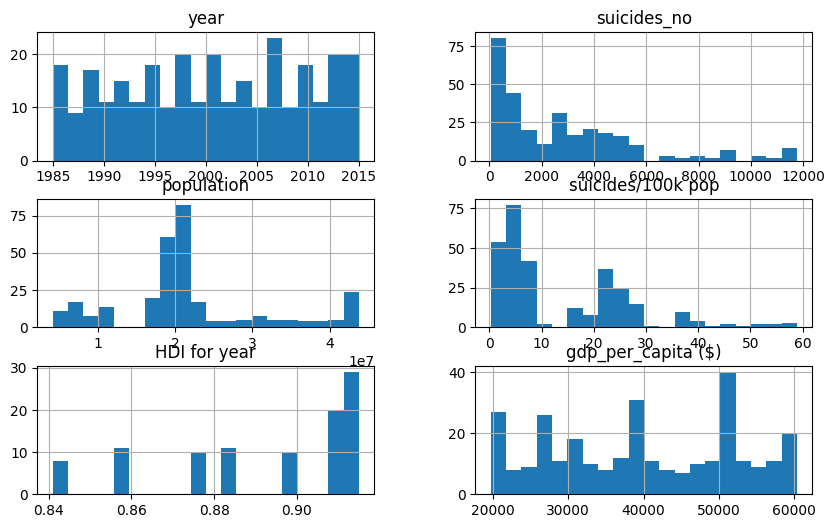

In [ ]:
train_set.hist(bins=20, figsize=(10, 6))

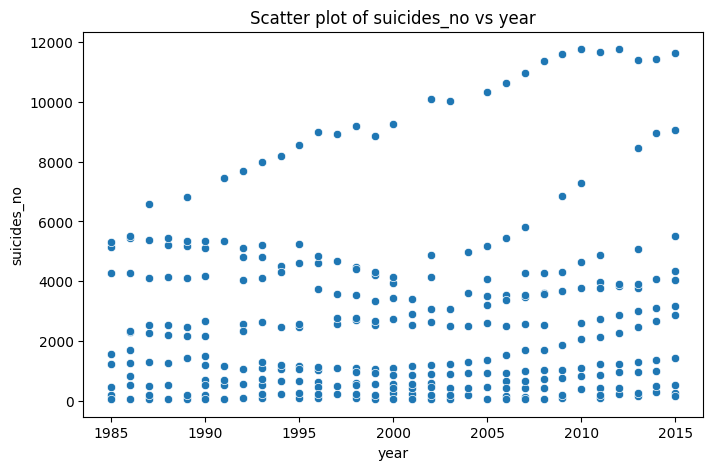

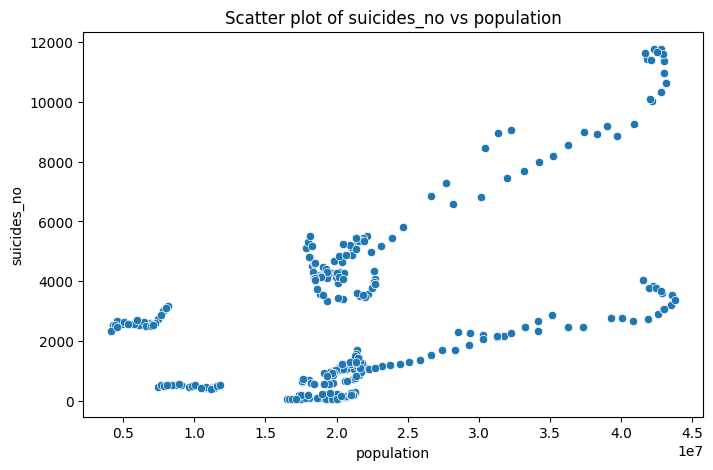

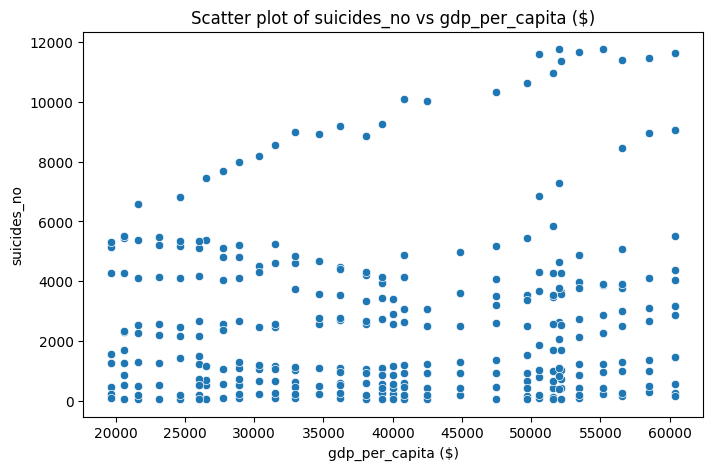

In [ ]:
features = ['year', 'population', 'gdp_per_capita ($)']
label = 'suicides_no'

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=train_set, x=feature, y=label)
    plt.title(f'Scatter plot of {label} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(label)
    plt.show()

In [ ]:
gr_suicvspop = train_set.groupby(by=["sex", "generation", "year"])[['suicides_no', 'population']].sum()
gr_suicvspop

suicides_no  population
sex    generation year                         
female Boomers    1985         1242    21041000
                  1986         1261    21391000
                  1987         1285    21645000
                  1988         1247    21822000
                  1990         1211    21596400
...                             ...         ...
male   Silent     2011         2721     7448796
                  2012         2853     7633574
                  2013         2990     7816638
                  2014         3106     7994948
                  2015         3171     8171136

[241 rows x 2 columns]

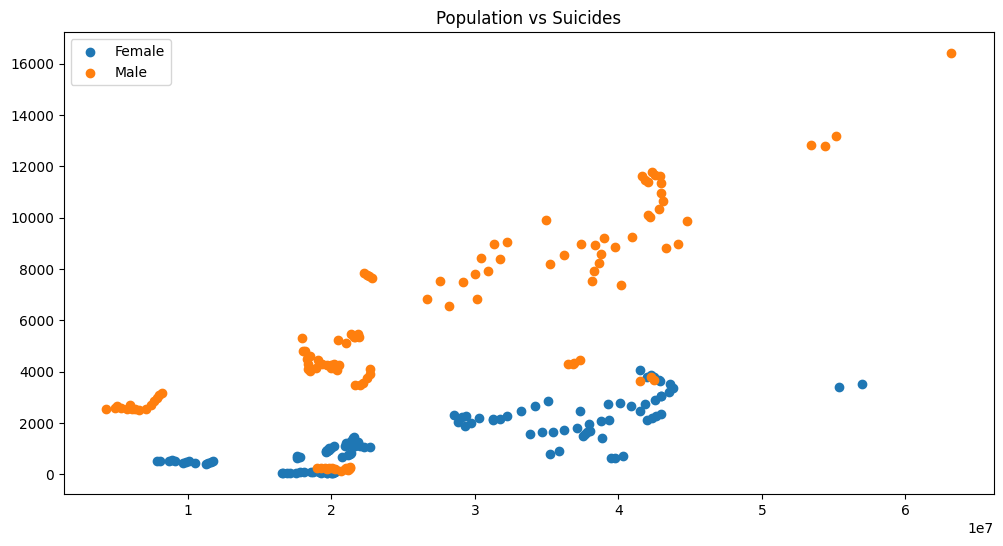

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(gr_suicvspop.loc['female']['population'], gr_suicvspop.loc['female']['suicides_no'], label="Female")
ax1.scatter(gr_suicvspop.loc['male']['population'], gr_suicvspop.loc['male']['suicides_no'], label="Male")

plt.title("Population vs Suicides")
plt.legend()

### Посмотрим на коэф. корреляции

In [ ]:
ts_corr = train_set[features + ['suicides_no']].corr()
ts_corr['suicides_no'].sort_values(ascending=False)

,suicides_no
suicides_no,1.000000
population,0.561819
year,0.107961
gdp_per_capita ($),0.107221


In [ ]:
# Изменим категориальное значение пола на sex_male
tcat_set = train_set.drop(columns=features).reset_index(drop=True)
tcat_set['sex_male'] = tcat_set['sex'].apply(lambda x: 1 if x == "male" else 0)
tcat_set.drop(columns=['sex', "HDI for year", "country", "country-year", "suicides/100k pop"], axis=1, inplace=True)

# Заменим значение возраста на взвешенное среднее
age_mapping = {
    "75+ years": 80,
    "55-74 years": (74 + 55) / 2,
    "35-54 years": (54 + 35) / 2,
    "5-14 years": (14 + 5) / 2,
    "25-34 years": (34 + 25) / 2,
    "15-24 years": (24 + 15) / 2,
}
tcat_set['age_midpoint'] = tcat_set['age'].map(age_mapping)
tcat_set.drop('age', axis=1, inplace=True)

# Конвертируем значение столбца "gpd_for_year" в числовые и разделим на 10^6
tcat_set['gdp_for_yearM'] = tcat_set[' gdp_for_year ($) '].apply(lambda x : np.float64(x.replace(',', '')) / (10**6))
tcat_set.drop(' gdp_for_year ($) ', axis=1, inplace=True)

tcat_set

,suicides_no,generation,sex_male,age_midpoint,gdp_for_yearM
0,143,Generation Z,0,9.5,16691517.0
1,2549,Silent,1,80.0,10621824.0
2,7454,Boomers,1,44.5,6174043.0
3,2573,G.I. Generation,1,80.0,6539299.0
4,3171,Silent,1,80.0,18120714.0
...,...,...,...,...,...
293,69,Generation X,0,9.5,5979589.0
294,233,Millenials,1,9.5,6878718.0
295,1684,Silent,0,64.5,14477635.0
296,3106,Silent,1,80.0,17427609.0


In [ ]:
# Используем метод One-Hot для поколений
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

tcat_cat = tcat_set[["generation"]] # saved DataFrame type
gen_tcat_1hot = cat_encoder.fit_transform(tcat_cat)

# Convert the sparse matrix to a dense array
gen_tcat_array = gen_tcat_1hot.toarray()

# Get the category names from the encoder
gen_tcat_names = cat_encoder.get_feature_names_out(['generation'])

# Create a DataFrame from the one-hot encoded array with appropriate column names
gen_df = pd.DataFrame(gen_tcat_array, columns=gen_tcat_names)

gen_df
# Concatenate the new DataFrame with the original nusa_df
tcat_set = pd.concat([tcat_set, gen_df], axis=1)

# Drop the original 'generation' column as it's no longer needed
tcat_set.drop('generation', axis=1, inplace=True)
tcat_set

,suicides_no,sex_male,age_midpoint,gdp_for_yearM,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,143,0,9.5,16691517.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2549,1,80.0,10621824.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7454,1,44.5,6174043.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2573,1,80.0,6539299.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3171,1,80.0,18120714.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
293,69,0,9.5,5979589.0,0.0,0.0,1.0,0.0,0.0,0.0
294,233,1,9.5,6878718.0,0.0,0.0,0.0,0.0,1.0,0.0
295,1684,0,64.5,14477635.0,0.0,0.0,0.0,0.0,0.0,1.0
296,3106,1,80.0,17427609.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
tcat_corr = tcat_set.corr()
tcat_corr['suicides_no'].sort_values(ascending=False)

,suicides_no
suicides_no,1.000000
sex_male,0.593475
generation_Boomers,0.421089
age_midpoint,0.164760
gdp_for_yearM,0.110948
generation_Generation X,0.046603
generation_Silent,-0.053476
generation_G.I. Generation,-0.088615
generation_Generation Z,-0.200455
generation_Millenials,-0.243744


## **Обрабатываем и исправляем данные**

In [ ]:
nusa_df = train_set.drop("HDI for year", axis=1).reset_index(drop=True)
nusa_df.drop("country", axis=1, inplace=True)
nusa_df.drop("country-year", axis=1, inplace=True)
nusa_df.drop("suicides/100k pop", axis=1, inplace=True)
nusa_df

,year,sex,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation
0,2013,female,5-14 years,143,20308672,"16,691,517,000,000",56520,Generation Z
1,2001,male,75+ years,2549,6285825,"10,621,824,000,000",40018,Silent
2,1991,male,35-54 years,7454,31995000,"6,174,043,000,000",26503,Boomers
3,1992,male,75+ years,2573,4916700,"6,539,299,000,000",27760,G.I. Generation
4,2015,male,75+ years,3171,8171136,"18,120,714,000,000",60387,Silent
...,...,...,...,...,...,...,...,...
293,1990,female,5-14 years,69,17124400,"5,979,589,000,000",26004,Generation X
294,1993,male,5-14 years,233,18972100,"6,878,718,000,000",28891,Millenials
295,2007,female,55-74 years,1684,27395858,"14,477,635,000,000",51585,Silent
296,2014,male,75+ years,3106,7994948,"17,427,609,000,000",58531,Silent


In [ ]:
# Изменим категориальное значение пола на sex_male
nusa_df['sex_male'] = nusa_df['sex'].apply(lambda x: 1 if x == "male" else 0)
nusa_df.drop('sex', axis=1, inplace=True)
nusa_df

,year,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation,sex_male
0,2013,5-14 years,143,20308672,"16,691,517,000,000",56520,Generation Z,0
1,2001,75+ years,2549,6285825,"10,621,824,000,000",40018,Silent,1
2,1991,35-54 years,7454,31995000,"6,174,043,000,000",26503,Boomers,1
3,1992,75+ years,2573,4916700,"6,539,299,000,000",27760,G.I. Generation,1
4,2015,75+ years,3171,8171136,"18,120,714,000,000",60387,Silent,1
...,...,...,...,...,...,...,...,...
293,1990,5-14 years,69,17124400,"5,979,589,000,000",26004,Generation X,0
294,1993,5-14 years,233,18972100,"6,878,718,000,000",28891,Millenials,1
295,2007,55-74 years,1684,27395858,"14,477,635,000,000",51585,Silent,0
296,2014,75+ years,3106,7994948,"17,427,609,000,000",58531,Silent,1


In [ ]:
# Заменим значение возраста на взвешенное среднее
age_mapping = {
    "75+ years": 80,
    "55-74 years": (74 + 55) / 2,
    "35-54 years": (54 + 35) / 2,
    "5-14 years": (14 + 5) / 2,
    "25-34 years": (34 + 25) / 2,
    "15-24 years": (24 + 15) / 2,
}

nusa_df['age_midpoint'] = nusa_df['age'].map(age_mapping)
nusa_df.drop('age', axis=1, inplace=True)
nusa_df

,year,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation,sex_male,age_midpoint
0,2013,143,20308672,"16,691,517,000,000",56520,Generation Z,0,9.5
1,2001,2549,6285825,"10,621,824,000,000",40018,Silent,1,80.0
2,1991,7454,31995000,"6,174,043,000,000",26503,Boomers,1,44.5
3,1992,2573,4916700,"6,539,299,000,000",27760,G.I. Generation,1,80.0
4,2015,3171,8171136,"18,120,714,000,000",60387,Silent,1,80.0
...,...,...,...,...,...,...,...,...
293,1990,69,17124400,"5,979,589,000,000",26004,Generation X,0,9.5
294,1993,233,18972100,"6,878,718,000,000",28891,Millenials,1,9.5
295,2007,1684,27395858,"14,477,635,000,000",51585,Silent,0,64.5
296,2014,3106,7994948,"17,427,609,000,000",58531,Silent,1,80.0


In [ ]:
# Конвертируем значение столбца "gpd_for_year" в числовые и разделим на 10^6
nusa_df['gdp_for_yearM'] = nusa_df[' gdp_for_year ($) '].apply(lambda x : np.float64(x.replace(',', '')) / (10**6))
nusa_df.drop(' gdp_for_year ($) ', axis=1, inplace=True)

## **Продолжаем преобразовывать данные**

In [ ]:
# Используем метод One-Hot для поколений
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

gen_cat = nusa_df[["generation"]] # saved DataFrame type
gen_cat_1hot = cat_encoder.fit_transform(gen_cat)
gen_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 298 stored elements and shape (298, 6)>

In [ ]:
gen_cat_1hot.toarray()

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.feature_names_in_

array(['generation'], dtype=object)

In [ ]:
# Convert the sparse matrix to a dense array
gen_cat_array = gen_cat_1hot.toarray()

# Get the category names from the encoder
gen_cat_names = cat_encoder.get_feature_names_out(['generation'])

# Create a DataFrame from the one-hot encoded array with appropriate column names
gen_df = pd.DataFrame(gen_cat_array, columns=gen_cat_names)

# Concatenate the new DataFrame with the original nusa_df
nusa_df = pd.concat([nusa_df, gen_df], axis=1)

# Drop the original 'generation' column as it's no longer needed
nusa_df.drop('generation', axis=1, inplace=True)

nusa_df

,year,suicides_no,population,gdp_per_capita ($),sex_male,age_midpoint,gdp_for_yearM,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,2013,143,20308672,56520,0,9.5,16691517.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2001,2549,6285825,40018,1,80.0,10621824.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1991,7454,31995000,26503,1,44.5,6174043.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1992,2573,4916700,27760,1,80.0,6539299.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2015,3171,8171136,60387,1,80.0,18120714.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,1990,69,17124400,26004,0,9.5,5979589.0,0.0,0.0,1.0,0.0,0.0,0.0
294,1993,233,18972100,28891,1,9.5,6878718.0,0.0,0.0,0.0,0.0,1.0,0.0
295,2007,1684,27395858,51585,0,64.5,14477635.0,0.0,0.0,0.0,0.0,0.0,1.0
296,2014,3106,7994948,58531,1,80.0,17427609.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: >

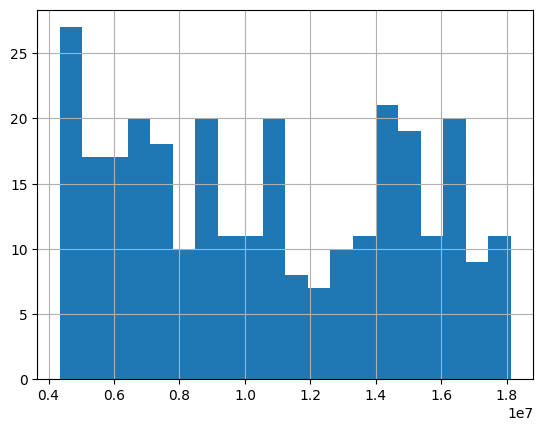

In [ ]:
nusa_df['gdp_for_yearM'].hist(bins=20)

## **Пробуем построить модель и проверить ее**

### Большой метод для преобразования данных

In [ ]:
def data_prep(data):
    from sklearn.preprocessing import OneHotEncoder

    ndata = data.drop(columns=["HDI for year", "country", "country-year", "suicides/100k pop"], axis=1).reset_index(drop=True)
    ndata['sex_male'] = ndata['sex'].apply(lambda x: 1 if x == "male" else 0)
    ndata.drop('sex', axis=1, inplace=True)
    age_mapping = {
        "75+ years": 80,
        "55-74 years": (74 + 55) / 2,
        "35-54 years": (54 + 35) / 2,
        "5-14 years": (14 + 5) / 2,
        "25-34 years": (34 + 25) / 2,
        "15-24 years": (24 + 15) / 2,
    }

    ndata['age_midpoint'] = ndata['age'].map(age_mapping)
    ndata.drop('age', axis=1, inplace=True)

    # Конвертируем значение столбца "gpd_for_year" в числовые и разделим на 10^6
    ndata['gdp_for_yearM'] = ndata[' gdp_for_year ($) '].apply(lambda x : np.float64(x.replace(',', '')) / (10**6))
    ndata.drop(' gdp_for_year ($) ', axis=1, inplace=True)

    # Используем метод One-Hot для поколений
    cat_encoder = OneHotEncoder()

    gen_cat = ndata[["generation"]] # saved DataFrame type
    gen_cat_1hot = cat_encoder.fit_transform(gen_cat)
    gen_cat_1hot

    # Convert the sparse matrix to a dense array
    gen_cat_array = gen_cat_1hot.toarray()

    # Get the category names from the encoder
    gen_cat_names = cat_encoder.get_feature_names_out(['generation'])

    # Create a DataFrame from the one-hot encoded array with appropriate column names
    gen_df = pd.DataFrame(gen_cat_array, columns=gen_cat_names)

    # Concatenate the new DataFrame with the original ndata
    ndata = pd.concat([ndata, gen_df], axis=1)

    # Drop the original 'generation' column as it's no longer needed
    ndata.drop('generation', axis=1, inplace=True)

    return ndata

### Модель линейной регрессии

In [ ]:
trainX = nusa_df.drop('suicides_no', axis=1)
trainY = nusa_df[['suicides_no']]
trainX

,year,population,gdp_per_capita ($),sex_male,age_midpoint,gdp_for_yearM,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,2013,20308672,56520,0,9.5,16691517.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2001,6285825,40018,1,80.0,10621824.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1991,31995000,26503,1,44.5,6174043.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1992,4916700,27760,1,80.0,6539299.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2015,8171136,60387,1,80.0,18120714.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
293,1990,17124400,26004,0,9.5,5979589.0,0.0,0.0,1.0,0.0,0.0,0.0
294,1993,18972100,28891,1,9.5,6878718.0,0.0,0.0,0.0,0.0,1.0,0.0
295,2007,27395858,51585,0,64.5,14477635.0,0.0,0.0,0.0,0.0,0.0,1.0
296,2014,7994948,58531,1,80.0,17427609.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(trainX, trainY)

LinearRegression()

In [ ]:
test_data = data_prep(test_set)
testX = test_data.drop('suicides_no', axis=1)
testY = test_data[['suicides_no']]
testX

,year,population,gdp_per_capita ($),sex_male,age_midpoint,gdp_for_yearM,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,2012,21028158,55170,1,29.5,16155255.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1987,18925000,21631,0,19.5,4870217.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1986,27363000,20588,1,44.5,4590155.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2011,28556351,53452,1,64.5,15517926.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1989,18055000,24654,0,19.5,5657693.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69,1991,18388000,26503,1,9.5,6174043.0,0.0,0.0,0.0,0.0,1.0,0.0
70,1992,18668200,27760,1,9.5,6539299.0,0.0,0.0,0.0,0.0,1.0,0.0
71,2001,20013572,40018,1,29.5,10621824.0,0.0,0.0,1.0,0.0,0.0,0.0
72,2010,20250632,51989,0,9.5,14964372.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
testY

,suicides_no
0,4985
1,815
2,6450
3,7572
4,764
...,...
69,208
70,232
71,4199
72,87


In [ ]:

test_predictions = model.predict(testX)

In [ ]:
test_predictions[:5]

array([[4063.62691407],
       [ 750.12035263],
       [5284.61508058],
       [7310.3824817 ],
       [ 398.79086747]])

In [ ]:
testY.to_numpy()

array([[ 4985],
       [  815],
       [ 6450],
       [ 7572],
       [  764],
       [   98],
       [ 4073],
       [   88],
       [ 3604],
       [  516],
       [ 3399],
       [ 6528],
       [  627],
       [  491],
       [   74],
       [ 6558],
       [ 2177],
       [ 4142],
       [   85],
       [ 2362],
       [  854],
       [ 2589],
       [ 2673],
       [  720],
       [ 4053],
       [ 2594],
       [  607],
       [ 4603],
       [ 9684],
       [ 1132],
       [ 5482],
       [ 2629],
       [ 1504],
       [  151],
       [ 2552],
       [  514],
       [ 7260],
       [  199],
       [  988],
       [  469],
       [  714],
       [  389],
       [ 1596],
       [ 4156],
       [ 5295],
       [ 4132],
       [ 1325],
       [ 1226],
       [ 2105],
       [  786],
       [  431],
       [ 4514],
       [  154],
       [ 4941],
       [  204],
       [ 4018],
       [  649],
       [ 6053],
       [ 5222],
       [ 2296],
       [ 2586],
       [  187],
       [

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

lin_rmse = root_mean_squared_error(testY.to_numpy(), test_predictions)
lin_mae = mean_absolute_error(testY.to_numpy(), test_predictions)

In [ ]:
lin_rmse

1171.5452269163072

In [ ]:
lin_mae

882.3890414329919

### Модель дерева выбора

In [ ]:
from sklearn.tree import DecisionTreeRegressor

smodel = DecisionTreeRegressor()
smodel.fit(trainX, trainY)

DecisionTreeRegressor()

In [ ]:
stest_predictions = smodel.predict(testX)

In [ ]:
stest_predictions[0]

np.float64(5102.0)

In [ ]:
slin_rmse = root_mean_squared_error(testY.to_numpy(), stest_predictions)
slin_mae = mean_absolute_error(testY.to_numpy(), stest_predictions)

In [ ]:
slin_rmse

208.57712942439045

In [ ]:
slin_mae

121.58108108108108

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(smodel, testX, testY, scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
tree_rmses.sum() / len(tree_rmses)

np.float64(422.0781075195785)

In [ ]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,422.078108
std,279.800392
min,162.927131
25%,255.735949
50%,307.141374
75%,473.157957
max,1053.256972


### Модель случайного леса

In [ ]:
from sklearn.ensemble import RandomForestRegressor

tmodel = RandomForestRegressor(n_estimators=100, random_state=42)
tmodel.fit(trainX, trainY)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [ ]:
ttest_predictions = tmodel.predict(testX)

In [ ]:
testX.iloc[0].to_numpy()

array([2.0120000e+03, 2.1028158e+07, 5.5170000e+04, 1.0000000e+00,
       2.9500000e+01, 1.6155255e+07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00])

In [ ]:
tlin_rmse = root_mean_squared_error(testY.to_numpy(), ttest_predictions)
tlin_mae = mean_absolute_error(testY.to_numpy(), ttest_predictions)

In [ ]:
tlin_rmse

138.09216322657346

In [ ]:
tlin_mae

87.25581081081084

In [ ]:
from sklearn.model_selection import cross_val_score

ttree_rmses = -cross_val_score(tmodel, testX, testY, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

In [ ]:
pd.Series(ttree_rmses).describe()

,0
count,10.000000
mean,400.157883
std,110.242537
min,230.664693
25%,319.974413
50%,393.865916
75%,486.110931
max,544.082525


## **Сохраняем модель**

In [ ]:
import joblib

joblib.dump(smodel, "USA_suicide_pred_model.pkl")

['USA_suicide_pred_model.pkl']

In [ ]:
joblib.dump(tmodel, "USA_suicide_pred_model_1.pkl")

['USA_suicide_pred_model_1.pkl']